<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/try_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.data import Dataset
from keras.losses import Huber
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D, LSTM, Dense, Dropout
from keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

def time_step_generator(data, time_size, batch_size, shuffle_data):
  generate_data = Dataset.from_tensor_slices(data) # generate data series menjadi tensor
  add_window_time_step = generate_data.window(time_size+1, shift=1, drop_remainder=True) # membuat data kedalam kolom window yang baru
  flatten_window = add_window_time_step.flat_map(lambda window : window.batch(time_size+1)) # hasil pertambahan step data akan digabung menjadi satu array
  tuple_feature_label = flatten_window.map(lambda window: (window[:-1], window[-1])) # data akan dirubah menjadi feature dan label dengan ketentuan 1 data terakhir sabagai label
  shuffle_data = tuple_feature_label.shuffle(shuffle_data) # data yang sudah jadi akan di random sesuai dengan ukuran random data
  batch_window = shuffle_data.batch(batch_size).prefetch(1) # data akan disusun menjadi batch-batch tertentu sesuai dengan kebutuhan
  
  return batch_window

def forecast_predict(model, data, time_size, batch_size, shuffle_data):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

In [ ]:
data_url = 'https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_harga_bahan_pangan_indonesia.csv?raw=true'
urllib.request.urlretrieve(data_url, 'data_pangan_indonesia.csv')

data_pangan = pd.read_csv('data_pangan_indonesia.csv')
data_pangan.columns = data_pangan.columns.str.replace(' (kg)', '', regex=False).str.replace('(kg)', '', regex=False).str.replace(' ', '_').str.lower()
data_pangan['date'] = pd.to_datetime(data_pangan.date)
data_pangan = data_pangan.set_index('date')

<function matplotlib.pyplot.show(*args, **kw)>

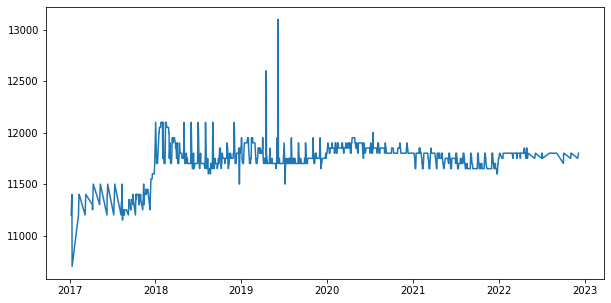

In [ ]:
data_pangan = data_pangan.sort_index()
plt.figure(figsize=(10, 5))
plt.plot(data_pangan.index.values, data_pangan.beras.values)
plt.show

In [ ]:
from os import initgroups
import scipy.stats as stats
Q1 = data_pangan.quantile(q=.25)
Q3 = data_pangan.quantile(q=.75)
IQR = Q3-Q1

low = Q1-1.5*IQR
high = Q3+1.5*IQR

IQRs = data_pangan.apply(stats.iqr)

lows = Q1-1.5*IQRs
highs = Q3+1.5*IQRs
# up = data_pangan['minyak_goreng'] >= (highs)
# low = data_pangan['minyak_goreng'] <= (lows)

# lower = np.where(low)
# uper = np.where(up)

# data_pangan['minyak_goreng']
clean = data_pangan[~((data_pangan < lows) | (data_pangan > highs)).any(axis=1)]

# out_bawang_putih = data_pangan.bawang_putih.loc[(data_pangan['bawang_putih'] > low) & (data_pangan['bawang_putih'] < high)]

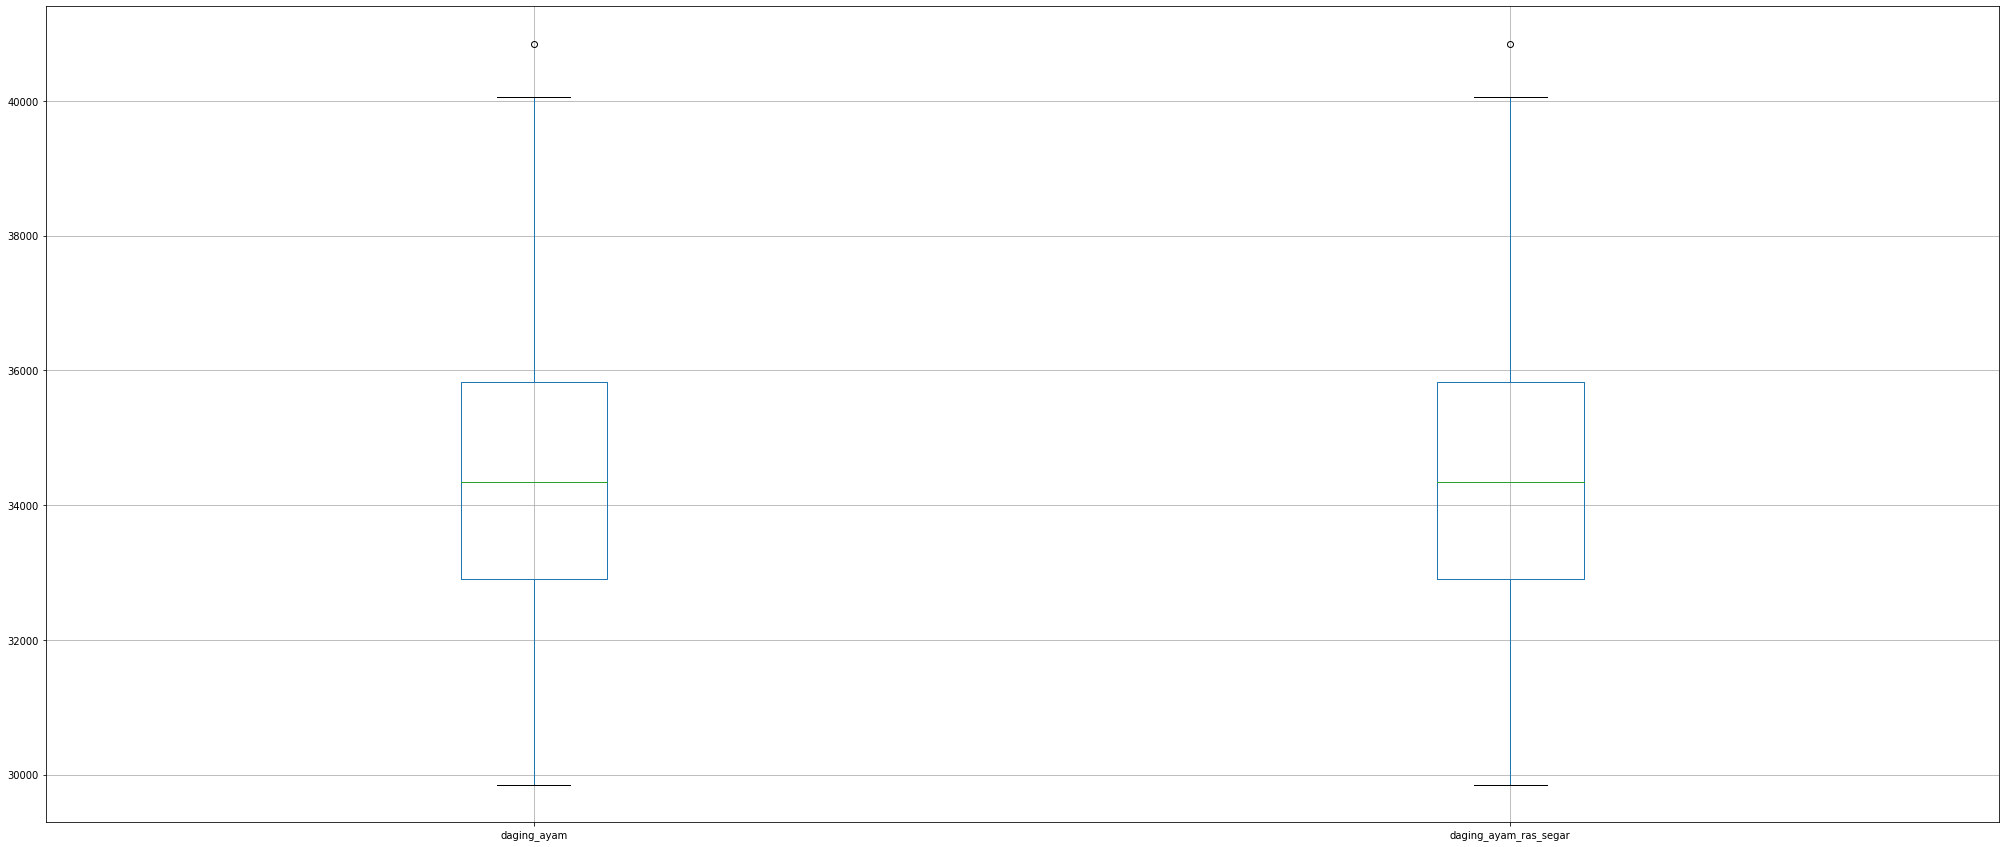

In [ ]:
clean.iloc[:, 7:9].boxplot(figsize=(35, 15))

In [ ]:
beras = data_pangan['beras'].values
date = data_pangan.index.values
x_train, x_test, y_train, y_test = train_test_split(beras, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=False, shuffle=False)
scaller = MinMaxScaler(feature_range=(0, 1))
scal_beras = scaller.fit_transform(x_train.reshape(-1, 1))
train_beras = time_step_generator(scal_beras, time_size=300, batch_size=10, shuffle_data=1000)
test_beras = time_step_generator(scaller.fit_transform(x_test.reshape(-1, 1)), time_size=150, batch_size=5, shuffle_data=100)
val_beras = time_step_generator(scaller.fit_transform(x_val.reshape(-1, 1)), time_size=80, batch_size=5, shuffle_data=1000)
len(beras)

1174

In [ ]:
bamer = data_pangan.bawang_merah.values
datess = data_pangan.index.values
x_trains, x_tests, y_train, y_tests = train_test_split(bamer, datess, test_size=0.2, random_state=False, shuffle=False)
x_trains, x_vals, y_trains, y_vals = train_test_split(x_trains, y_train, test_size=0.1, random_state=False, shuffle=False)
scaler = MinMaxScaler(feature_range=(0, 1))
scal_train_bamer = scaller.fit_transform(x_trains.reshape(-1, 1))
scal_test_bamer = scaller.fit_transform(x_tests.reshape(-1, 1))
scal_val_bamer = scaller.fit_transform(x_vals.reshape(-1, 1))
train_bamer = time_step_generator(scal_train_bamer, time_size=500, batch_size=10, shuffle_data=100)
test_bamer= time_step_generator(scal_test_bamer, time_size=150, batch_size=5, shuffle_data=100)
val_bamer = time_step_generator(scal_val_bamer, time_size=80, batch_size=5, shuffle_data=100)
len(x_tests)

235

In [ ]:
model= Sequential([
    Conv1D(4, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1]),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(512, activation='relu'),
    Dense(1)
    # tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 4)           24        
                                                                 
 lstm (LSTM)                 (None, None, 64)          17664     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 512)               16896     
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 47,513
Trainable params: 47,513
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss='mse', metrics=['mae', 'mape',])

In [ ]:
history = model.fit(train_beras, epochs=15, validation_data=val_beras)

Epoch 1/15
55/55 [==============================] - 12s 141ms/step - loss: 0.0111 - mae: 0.0566 - mape: 12.1237 - val_loss: 0.0631 - val_mae: 0.1809 - val_mape: 71486376.0000
Epoch 2/15
55/55 [==============================] - 7s 118ms/step - loss: 0.0025 - mae: 0.0358 - mape: 7.7269 - val_loss: 0.0626 - val_mae: 0.1811 - val_mape: 71005856.0000
Epoch 3/15
55/55 [==============================] - 7s 117ms/step - loss: 0.0024 - mae: 0.0352 - mape: 7.5904 - val_loss: 0.0621 - val_mae: 0.2051 - val_mape: 62881204.0000
Epoch 4/15
55/55 [==============================] - 7s 116ms/step - loss: 0.0027 - mae: 0.0375 - mape: 8.0313 - val_loss: 0.0617 - val_mae: 0.2018 - val_mape: 63866520.0000
Epoch 5/15
55/55 [==============================] - 8s 150ms/step - loss: 0.0020 - mae: 0.0299 - mape: 6.4108 - val_loss: 0.0615 - val_mae: 0.1985 - val_mape: 64963496.0000
Epoch 6/15
55/55 [==============================] - 7s 115ms/step - loss: 0.0020 - mae: 0.0312 - mape: 6.6947 - val_loss: 0.0619 - va

In [ ]:
model.evaluate(test_beras)

17/17 [==============================] - 0s 13ms/step - loss: 0.1126 - mae: 0.3191 - mape: 40.6654


[0.11258304864168167, 0.3190903067588806, 40.66535949707031]

<function matplotlib.pyplot.show(*args, **kw)>

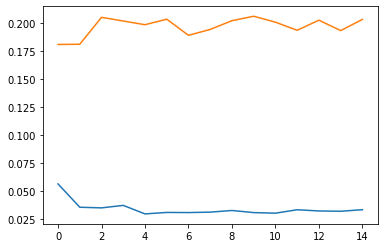

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.plot(epoch, mae)
plt.plot(epoch, val_mae)
plt.show

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
# from keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

test_beras_1 = x_vals
prediction = forecast_predict(model, test_beras_1, time_size=10, batch_size=10, shuffle_data=2)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_vals[:-9]
data_test = data_test.reshape(-1)

data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results.round()
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
print(f"mae= {mae}\nmape= {mape}")
data_new

9/9 [==============================] - 1s 6ms/step
mae= 2260.0363970588237
mape= 0.06784947622377069


,actual,prediction
0,31450,31271.0
1,34250,31253.0
2,34400,31253.0
3,31750,31252.0
4,31950,31237.0
...,...,...
80,33100,31244.0
81,33100,31244.0
82,33850,31244.0
83,31250,31226.0


In [ ]:
model.get

AttributeError: ignored

In [ ]:
data_new.to_csv(r'data_frame.csv', index=False, header=True)

In [ ]:
dates = y_test[:-9]
plt.figure(figsize=(10, 5))
plt.plot(dates, data_test)
plt.plot(dates, results)
plt.show

In [ ]:
tested = pd.read_excel('tested.xlsx', skiprows=8)
tested = tested.drop('No.', axis=1)
tested = tested.T.reset_index()
tested.columns = tested.loc[0]
tested = tested.drop(0)

tested = tested.rename(columns={'Komoditas(Rp)': 'Date'})
test_beras = tested['Beras'].values
minmaxtest = scaller.fit_transform(test_beras.reshape(-1, 1))
prediction_1 = forecast_predict(model, minmaxtest, time_size=3, batch_size=1, shuffle_data=1000)
result_1 = prediction_1.squeeze()
results_1 = result_1.reshape(-1, 1)
results_1 = scaller.inverse_transform(results_1).round(1)
results_1 = results_1.reshape(-1)
test_berass = test_beras[:-2]
date = tested['Date']
date = date[:-2]
new = pd.DataFrame()
new['date'] = date
new['actual'] = test_berass
new['prediction'] = results_1
minn = minmaxtest.reshape(-1)
minn = minn[:-2]
mae = mean_absolute_error(test_berass, results_1)
mape = mean_absolute_percentage_error(test_berass, results_1)
mae, mape

In [ ]:
data = scal_test_bamer.reshape(1, -1)
data_series = list(data)
data_series = data_series[0].tolist()

output = []
step = len(scal_test_bamer) - 1
i = 1
while(i<=100):
  if(len(data_series)>100):
    input = np.array(data_series[1:])
    print(f'{i} day with input {input}')
    input = input.reshape(1, -1)
    input = input.reshape((1, step, 1))
    print(input)
    y = model.predict(input, verbose=0)
    print(f'{i} day output {y}')
    data_series.extend(y[0].tolist())
    data_series = data_series[1:]
    output.extend(y.tolist())
    i = i+1
  else:
    input = np.array(data_series)
    input = input.reshape(1, step, 1)
    y = model.predict(input, verbose=0)
    print(y[0])
    data_series.extend(y[0].tolist())
    output.extend(y.tolist())
    i = i+1

np.array(scaller.inverse_transform(output)).round()

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
print(X)
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=500, verbose=0)
# demonstrate prediction
x_input = array([60, 70, 80, 90])
x_input = x_input.reshape((1, n_seq, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)